# Viral Load Curves

Viral load curves for viruses such as Influenza and SARS-CoV-2 follow a standard biphasic clearance curve consisting of: 1) A lag-phase corresponding to the incubation of the virus in latent infected cells. 2) Rapid exponential growth corresponding to the transition of infected cells from the early to the late state and release of the virus to the extracellular environment, 3) Saturation and slow decay associated with innate immune responses (Interferon and Macrophages/NK cells) and 4) Rapid decay associated with adaptive immune responses (CD8+ T-cells and Antibody secretion by B-cells).

### Influenza

<div>
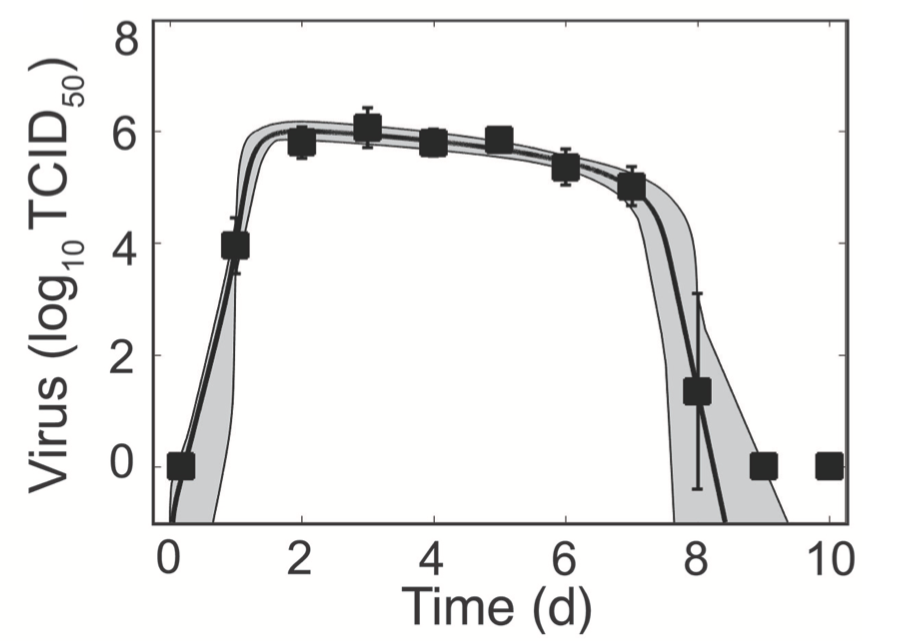
</div>

### SARS-CoV-2

<div>
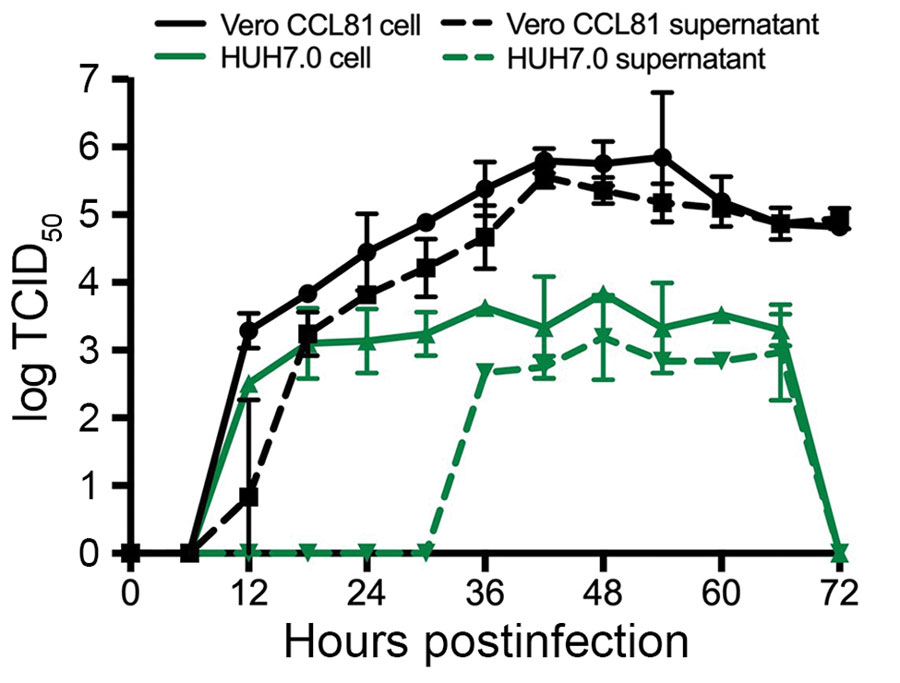
</div>

# Building a model of viral infection

We want to build a model that incorporates our understanding of the different processes that produce the characteristic viral load curve such that our model can reproduce the experimental data. We need to: 1) Identify the basic variables of our model and determine the interactions between them, 2) Build the model one variable at the time making and choose parameter values such that each step the model reproduces the different stages of the viral curve. 3) Fit the model to the data to get a better estimate of such parameters. 

# Transition from Uninfected to Early Infected
We start with a population of uninfected susceptible cells ($T$). The initial number of uninfected susceptible cells is $T_0$. Uninfected cells become infected ($I_1$) at a rate that is dependent on the amount of extracellular virus ($V$) and the infectivity of the virus ($\beta$).

$\frac{dT}{dt}=-\beta T V$ 

$\frac{dI_1}{dt}=\beta T V$

<div>
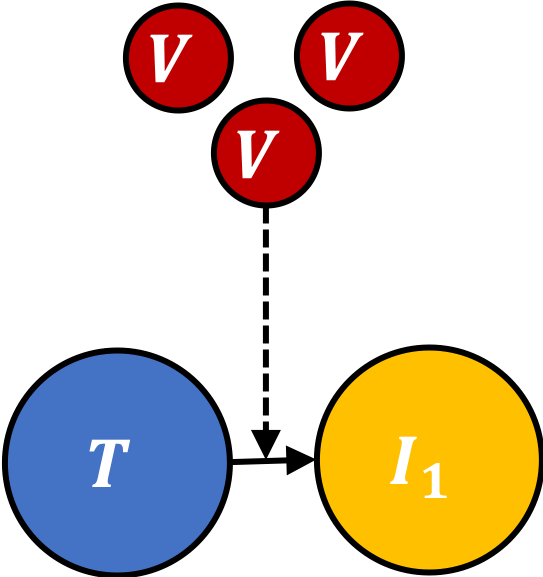
</div>

### Note on V

The variable $V$ is the total amount of virus in the system, which is assumed to be well-mixed. The rate of transition should dependent of the amount of virus per cell (or per cell area) $V/T_0$. Thus, the infectivity must be rescaled by the total number of cells in the system to recover the original rate equations.

$\frac{dT}{dt}=-\beta T_0 T \frac{V}{T_0} \rightarrow \frac{dT}{dt}=-\beta T V$

Aditionally, instead of using mass-action we might want the infection rate to saturate as we increase the amount of virus per cell.

$\frac{dT}{dt}=-\beta T V \frac{k_V}{k_V + V}$

However, mass-action is standard in the literature and we will continue to use it.

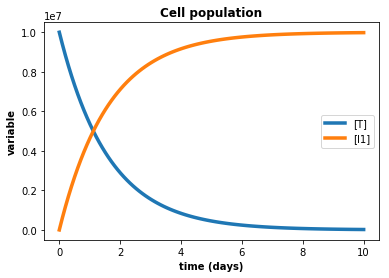

In [35]:
import tellurium as te
import matplotlib.pyplot as plt
model_string = '''
    //Equations
    E1: T -> I1 ; beta*T*V ; //Infection rate
    
    //Parameters
    beta = 6.2E-5 ; // 1.0/(TCID*day)
    
    //Inputs
    V = 10000.0
    
    //Initial Conditions
    T0 = 1E7
    T = T0
'''
m = te.loada(model_string)
s = m.simulate(0,10,100)
m.plot(title = "Cell population",xtitle="time (days)", ytitle="variable",linewidth=3.5)

# Transition from Early to Late Infected

Newly infected cells experience an incubation period in which virus is not yet release to the environment. Viral load curves show incubation periods of 6 hours for Influenza and 12 hours for SARS-CoV-2. Following the literature, we assume that the transtion rate from early to late infected is inversily proportial to the incubation period.

$\frac{dI_1}{dt}=\beta T V - k I_1$

$\frac{dI_2}{dt}=k I_1$


<div>
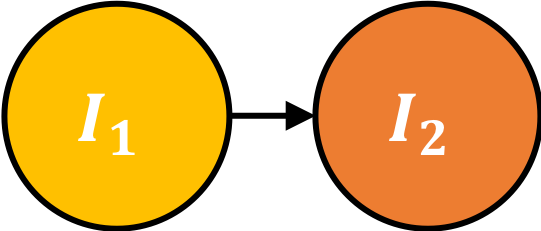
</div>

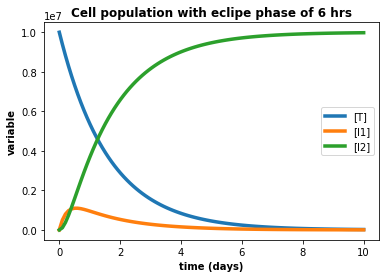

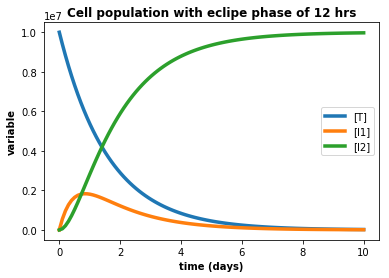

In [34]:
import tellurium as te
model_string = '''
    //Equations
    E1: T -> I1 ; beta*T*V ; //Infection rate
    E2: I1 -> I2 ; k*I1 ; //Infection rate
    
    //Parameters
    beta = 6.2E-5 ; // 1.0/(TCID*day)
    k = 0.0 ; // 1.0/day
    
    //Inputs
    V = 10000.0
    
    //Initial Conditions
    T0 = 1E7
    T = T0
'''
# Influenza Ecplise Phase (6 hrs)
m = te.loada(model_string)
m.k = 1.0/6.0 * 24.0
s = m.simulate(0,10,100)
m.plot(title="Cell population with eclipe phase of 6 hrs", xtitle="time (days)", ytitle="variable",linewidth=3.5)
# SARS-CoV-2 Ecplise Phase (12 hrs)
m = te.loada(model_string)
m.k = 1.0/12.0 * 24.0
s = m.simulate(0,10,100)
m.plot(title = "Cell population with eclipe phase of 12 hrs", xtitle="time (days)", ytitle="variable",linewidth=3.5)

# Virus Production

Cells in the late infected state produce and release virus to the extracellular environment. Experimentally, viral production is measured as 10-fold increases over the exponential phase of the virus. Standard models assume that infected cells in the late stage produce a constant amount of virus per time.

$\frac{dV}{dt}= pI_2$

<div>
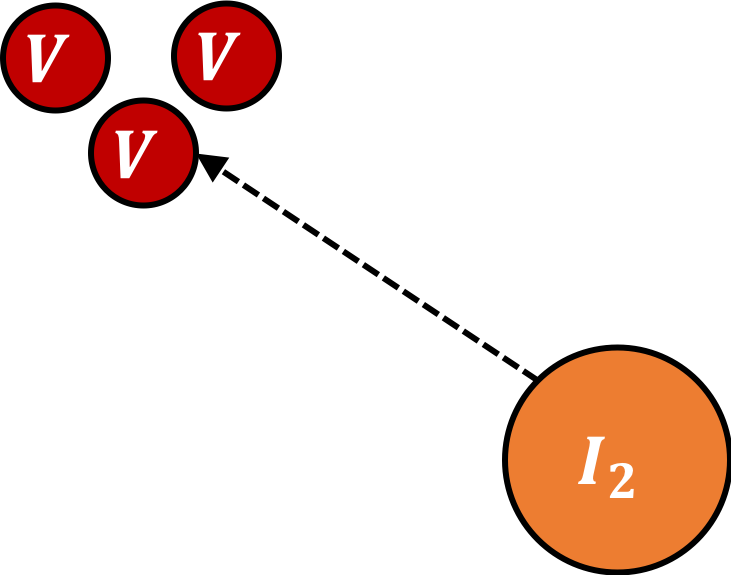
</div>

We can model the exponential phase of the virus by putting all the equations together without having to incorporate virus decay in the extracellular environment or clearance of late infected cells. We can fit this model to the data corresponding to the exponential phase of the virus.

<div>
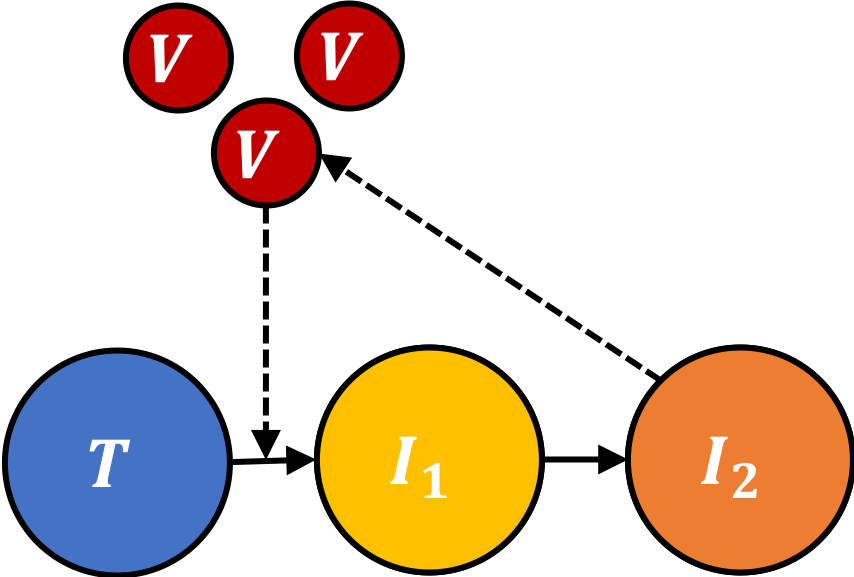
</div>

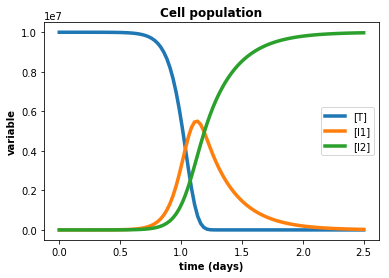

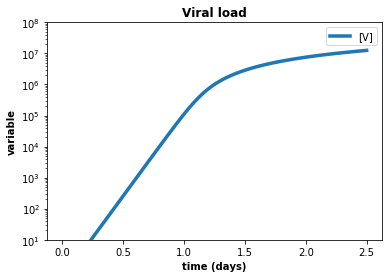

In [59]:
import tellurium as te
model_string = '''
    //Equations
    E1: T -> I1 ; beta*T*V ; //Infection rate
    E2: I1 -> I2 ; k*I1 ; //Infection rate
    E3: -> V ; p*I2 ; //Virus Production
    
    //Parameters
    beta = 6.2E-5 ; // 1.0/(TCID*day)
    k = 4.0 ; // 1.0/day
    p = 1.0 ; // TCID/cell/day

    //Inputs
    V = 0.0
    
    //Initial Conditions
    T0 = 1E7
    T = T0
    I1 = 75 
'''
m = te.loada(model_string)
s = m.simulate(0,2.5,100,['time','[T]','[I1]','[I2]'])
m.plot(title = "Cell population", xtitle="time (days)", ytitle="variable",linewidth=3.5)
m = te.loada(model_string)
s = m.simulate(0,2.5,100,['time','[V]'])
m.plot(title = "Viral load", xtitle="time (days)", ytitle="variable",linewidth=3.5,yscale='log',ylim=[10E0,10E7])

# Virus Decay

Extracellular virus has a lifespan in which it can infect cells and after which it degrades and its not longer infectious. We next add a virus decay that is proportional to the amount of extracellular virus. The viral load curves show that the amount of extracellular virus reaches a plateau.

$\frac{dV}{dt}= pI_2 - cV$

<div>
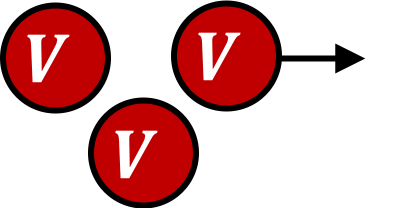
</div>

Now we can model the exponential phase of the virus and the saturation.

<div>
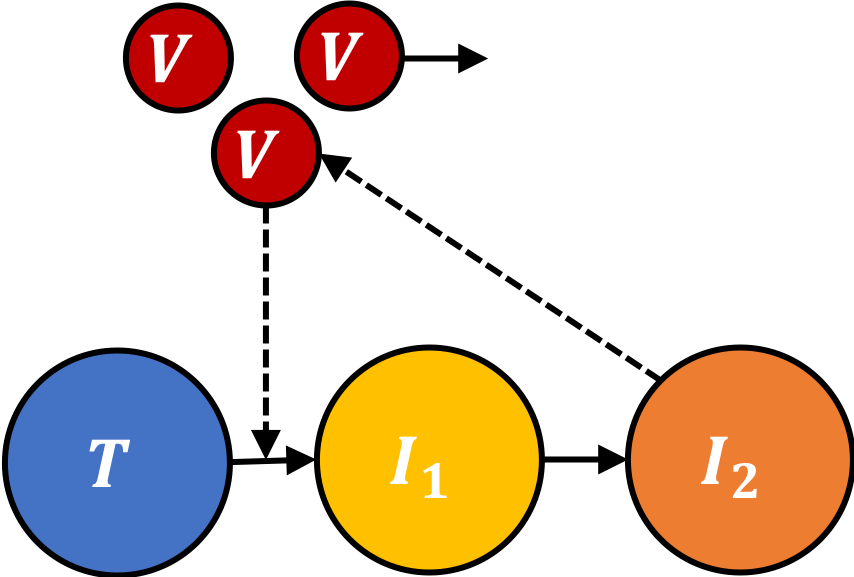
</div>

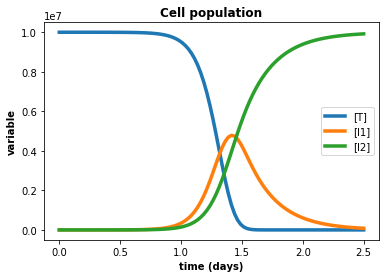

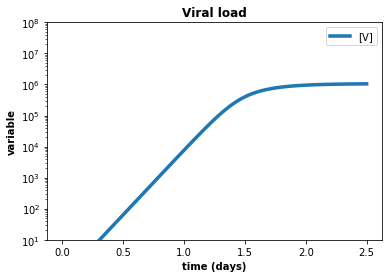

In [60]:
import tellurium as te
model_string = '''
    //Equations
    E1: T -> I1 ; beta*T*V ; //Infection rate
    E2: I1 -> I2 ; k*I1 ; //Infection rate
    E3: -> V ; p*I2 ; //Virus Production
    E4: V -> ; c*V ; // Virus Decay
    
    //Parameters
    beta = 6.2E-5 ; // 1.0/(TCID*day)
    k = 4.0 ; // 1.0/day
    p = 1.0 ; // TCID/cell/day
    c = 9.4 ; // 1.0/day

    //Inputs
    V = 0.0
    
    //Initial Conditions
    T0 = 1E7
    T = T0
    I1 = 75 
'''
m = te.loada(model_string)
s = m.simulate(0,2.5,100,['time','[T]','[I1]','[I2]'])
m.plot(title = "Cell population", xtitle="time (days)", ytitle="variable",linewidth=3.5)
m = te.loada(model_string)
s = m.simulate(0,2.5,100,['time','[V]'])
m.plot(title = "Viral load", xtitle="time (days)", ytitle="variable",linewidth=3.5,yscale='log',ylim=[10E0,10E7])

# Infected Cell Clearance due to Viral Infection and Innate Immune Response

Infected cells have an average lifespan before they die from viral infection. In vitro, cell death is mediated by complex apoptotic and pyroptotic cell death pathways. Experimentally the typical lifetime of a virus producing infected cell is about 12 hours for Influenza and 24-48 hours for SARS-CoV-2. In vivo, this death rate also aggregates non-adaptive immune system killing of cells (e.g. NK cells). Although cell death is dependent on the amount of viral proteins and genomic material inside the cells, we can approximate the death rate in our population to be first-order on the number of virus producing cells.

$\frac{dI_2}{dt}= kI_1 - dI_2$

$\frac{dD}{dt}= dI_2$

<div>
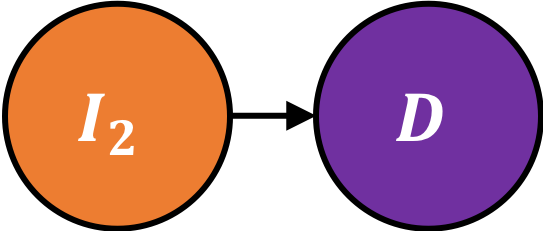
</div>

We expect the clearance of the infected cells to result in a slow decrease in the amount of extracellular virus from the previously observed stead-state value. To achieve late rapid clearance we will need to model the adapative immune response.

<div>
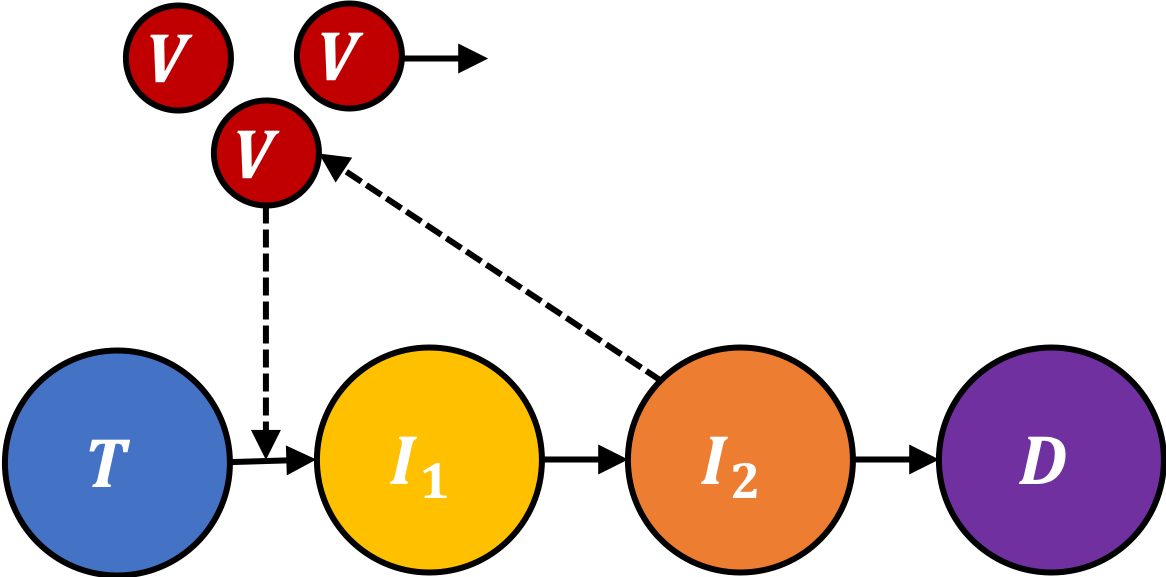
</div>

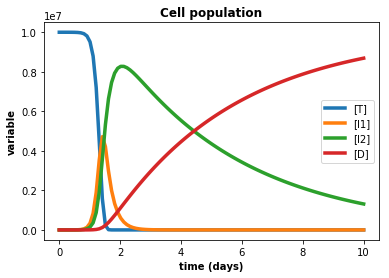

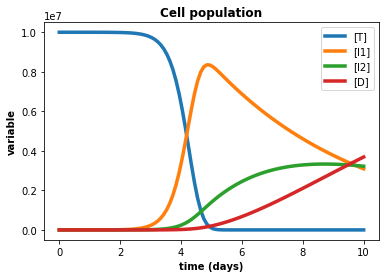

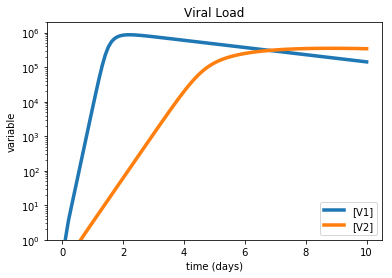

In [81]:
import tellurium as te
model_string = '''
    //Equations
    E1: T -> I1 ; beta*T*V ; //Infection rate
    E2: I1 -> I2 ; k*I1 ; //Infection rate
    E3: -> V ; p*I2 ; //Virus Production
    E4: V -> ; c*V ; // Virus Decay
    E5: I2 -> D ; d*I2 ; // Infected Cell Clearance (apopotosis + innate immune response)
    
    
    //Parameters
    beta = 6.2E-5 ; // 1.0/(TCID*day)
    k = 4.0 ; // 1.0/day
    p = 1.0 ; // TCID/cell/day
    c = 9.4 ; // 1.0/day
    d = 2.4E-1; // 1.0/day

    //Inputs
    V = 0.0
    
    //Initial Conditions
    T0 = 1E7
    T = T0
    I1 = 75 
'''

# Latent period of 6 hours (Influenza)
m = te.loada(model_string)
s = m.simulate(0,10,100,['time','[T]','[I1]','[I2]','[D]'])
m.plot(title = "Cell population", xtitle="time (days)", ytitle="variable",linewidth=3.5)
# Latent period of 10 days
m1 = te.loada(model_string)
m1.k = 0.2
s1 = m1.simulate(0,10,100,['time','[T]','[I1]','[I2]','[D]'])
m1.plot(title = "Cell population", xtitle="time (days)", ytitle="variable",linewidth=3.5)


m = te.loada(model_string)
s = m.simulate(0,10,100,['time','[V]'])
m1 = te.loada(model_string)
m1.k = 0.2
s1 = m1.simulate(0,10,100,['time','[V]'])

import matplotlib.pyplot as plt
plt.plot(s['time'],s['[V]'],label = '[V1]',linewidth=3.5)
plt.plot(s1['time'],s1['[V]'],label = '[V2]',linewidth=3.5)
plt.yscale('log')
plt.title('Viral Load')
plt.xlabel('time (days)')
plt.ylabel('variable')
plt.ylim([1,None])
plt.legend()
plt.show()

# Adaptive Immune Response

So far, our model doesn’t incorporate the adapative immune system. When cells get infected they release pro-inflammatory cytokines that signal the immune system that they are infected. These cytokines are transported to the lymph node where they regulate replication of adaptive immune cells. Adaptive immune cells travel thorugh the lymphatyic and ciruclatory system to the infection site. Adaptive T-cells kill the infected cells they come into contact with. Adding the adaptive immune response will allow us to reproduce the byphasic viral curve.

# Cytokine Production And Decay

Let’s start with cytokine production, we’ll make it cytokine ($C$) production proportional to the whole infected population (both the cells that are in the eclipse phase and releasing virus to the environment). The cytokine curve will resemble the viral load curve.

$\frac{dC}{dt}= p_c(I_1+I_2) - c_cC$

<div>
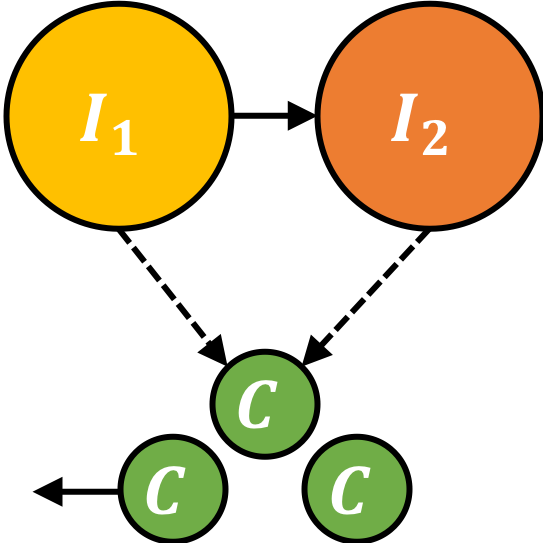
</div>

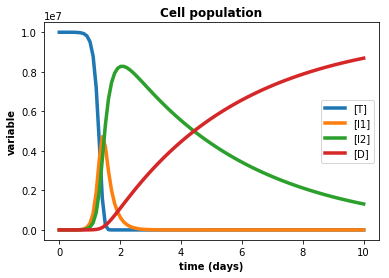

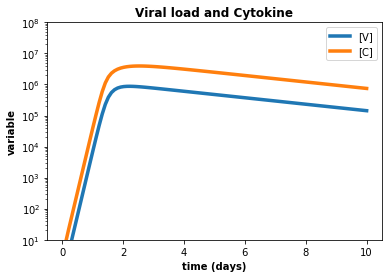

In [84]:
import tellurium as te
model_string = '''
    //Equations
    E1: T -> I1 ; beta*T*V ; //Infection rate
    E2: I1 -> I2 ; k*I1 ; //Infection rate
    E3: -> V ; p*I2 ; //Virus Production
    E4: V -> ; c*V ; // Virus Decay
    E5: I2 -> D ; d*I2 ; // Infected Cell Clearance (apopotosis + innate immune response)
    E6: -> C ; pc*(I1+I2) ; // Cytokine production
    E7: C -> ; cc*C ; // Cytokine decay
    
    
    //Parameters
    beta = 6.2E-5 ; // 1.0/(TCID*day)
    k = 4.0 ; // 1.0/day
    p = 1.0 ; // TCID/cell/day
    c = 9.4 ; // 1.0/day
    d = 2.4E-1; // 1.0/day
    pc = 1.0 ;
    cc = 2.0 ; // 1.0/day

    //Inputs
    V = 0.0
    
    //Initial Conditions
    T0 = 1E7
    T = T0
    I1 = 75
'''
m = te.loada(model_string)
s = m.simulate(0,10,100,['time','[T]','[I1]','[I2]','[D]'])
m.plot(title = "Cell population", xtitle="time (days)", ytitle="variable",linewidth=3.5)

m = te.loada(model_string)
s = m.simulate(0,10,100,['time','[V]','[C]'])
m.plot(title = "Viral load and Cytokine", xtitle="time (days)", ytitle="variable",linewidth=3.5,yscale='log',ylim=[10E0,10E7])

# Cytokine Transport to the Lymph Node

We will now add the transport of cytokine to the lymph node. We will separate the total cytokine into cytokine in tissue ($C$) and cytokine in lymph node ($C_L$). The rate of transport of cytokine to the lymph node is proportional to the amount of cytokine in the tissue and the transport rate, that represents the time it takes the cytokine to travel from the infection site to a nearby lymph node. We will also need a first-order decay of the lypmhatic cytokine. We will asume that it takes 4 days for cytokines to reach the lymph node.

$\frac{dC}{dt}= p_c(I_1+I_2) - c_cC - k_cC$

$\frac{dC_L}{dt}= k_cC - c_{cl}C_L$

<div>
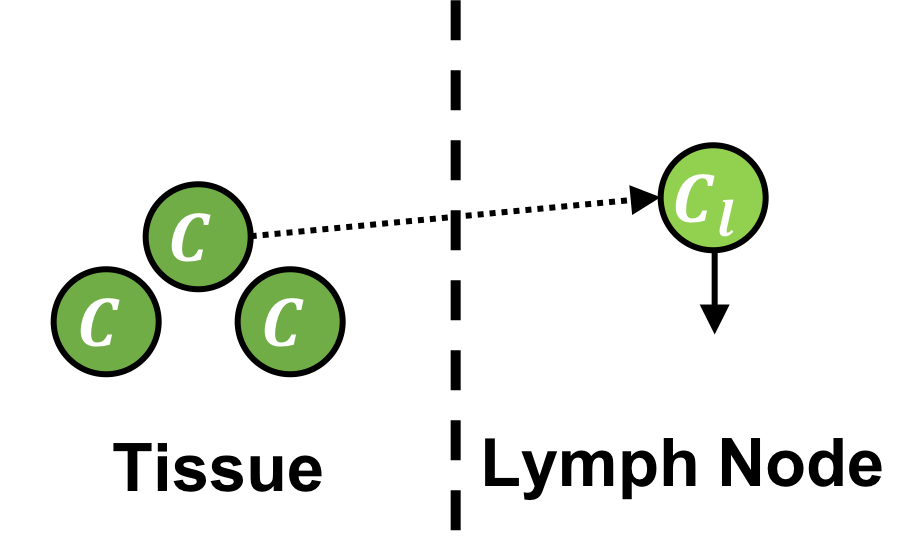
</div>

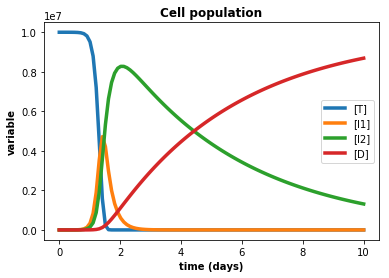

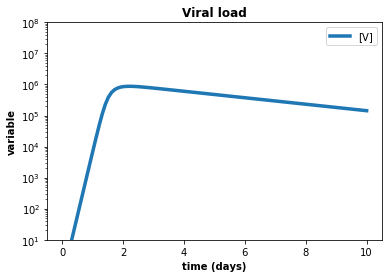

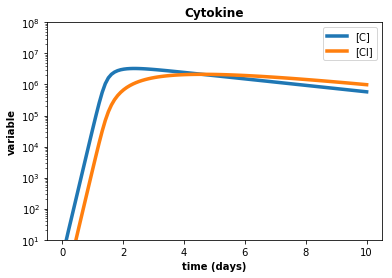

In [88]:
import tellurium as te
model_string = '''
    //Equations
    E1: T -> I1 ; beta*T*V ; //Infection rate
    E2: I1 -> I2 ; k*I1 ; //Infection rate
    E3: -> V ; p*I2 ; //Virus Production
    E4: V -> ; c*V ; // Virus Decay
    E5: I2 -> D ; d*I2 ; // Infected Cell Clearance (apopotosis + innate immune response)
    E6: -> C ; pc*(I1+I2) ; // Cytokine production
    E7: C -> ; cc*C ; // Cytokine decay
    E8: C -> Cl ; kc * C // Cytokine transport to the lymph node
    E9: Cl -> ; ccl * Cl // Lymph node cytokine decay
    
    
    //Parameters
    beta = 6.2E-5 ; // 1.0/(TCID*day)
    k = 4.0 ; // 1.0/day
    p = 1.0 ; // TCID/cell/day
    c = 9.4 ; // 1.0/day
    d = 2.4E-1; // 1.0/day
    pc = 1.0 ;
    cc = 2.0 ; // 1.0/day
    kc = 0.5 ; // 1.0/day
    ccl = 0.5 ; // 1.0/day

    //Inputs
    V = 0.0
    
    //Initial Conditions
    T0 = 1E7
    T = T0
    I1 = 75
'''
m = te.loada(model_string)
s = m.simulate(0,10,100,['time','[T]','[I1]','[I2]','[D]'])
m.plot(title = "Cell population", xtitle="time (days)", ytitle="variable",linewidth=3.5)

m = te.loada(model_string)
s = m.simulate(0,10,100,['time','[V]'])
m.plot(title = "Viral load", xtitle="time (days)", ytitle="variable",linewidth=3.5,yscale='log',ylim=[10E0,10E7])
                         
m = te.loada(model_string)
s = m.simulate(0,10,100,['time','[C]','[Cl]'])
m.plot(title = "Cytokine", xtitle="time (days)", ytitle="variable",linewidth=3.5,yscale='log',ylim=[10E0,10E7])

# Tcell Proliferation in the Lymph Node

Now we can add the production of effector immune cells in the lymph node ($E_L$). Effector T-cells (and B-cells) proliferation is promoted by cytokine in the lymph node ($C_L$). We assume that proliferation of effector T-cells ($E_L$) is initiated and regulated by the lymph node cytokine ($C_L$). We also assume that the replication rate of lymph node effector cells saturates as the number of cells increases.

$\frac{dE_L}{dt} = p_{el}C_L + r_{el} C_L E_L\frac{K_{el}}{E_L + K_{el}}$

<div>
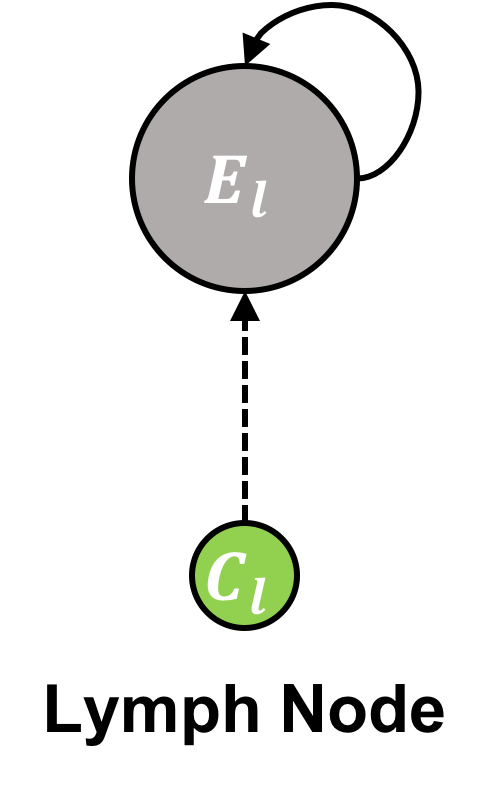
</div>

### Note on the Tcell expansion equations

The specific functional form of the rate of production of effector T-cells can have many forms depending on the motivating biological hypothesis, the understanding of mechanisms and the known and measurable kinetic rates of cell proliferation.

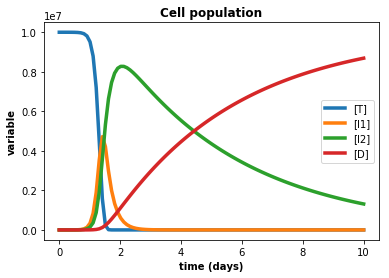

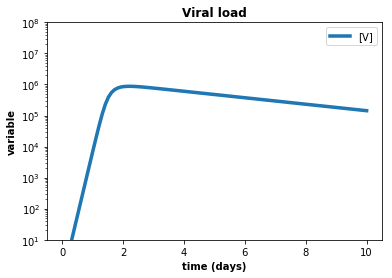

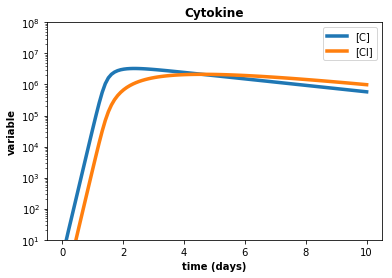

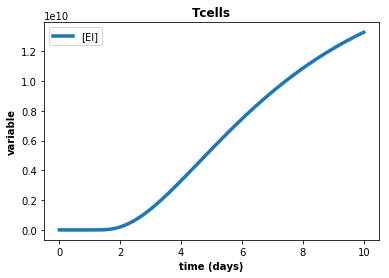

In [92]:
import tellurium as te
model_string = '''
    //Equations
    E1: T -> I1 ; beta*T*V ; //Infection rate
    E2: I1 -> I2 ; k*I1 ; //Infection rate
    E3: -> V ; p*I2 ; //Virus Production
    E4: V -> ; c*V ; // Virus Decay
    E5: I2 -> D ; d*I2 ; // Infected Cell Clearance (apopotosis + innate immune response)
    E6: -> C ; pc*(I1+I2) ; // Cytokine production
    E7: C -> ; cc*C ; // Cytokine decay
    E8: C -> Cl ; kc * C // Cytokine transport to the lymph node
    E9: Cl -> ; ccl * Cl // Lymph node cytokine decay
    E10: -> El ; pel*Cl + rel*Kel*Cl*El/(Kel + El) ;
    
    
    //Parameters
    beta = 6.2E-5 ; // 1.0/(TCID*day)
    k = 4.0 ; // 1.0/day
    p = 1.0 ; // TCID/cell/day
    c = 9.4 ; // 1.0/day
    d = 2.4E-1; // 1.0/day
    pc = 1.0 ;
    cc = 2.0 ; // 1.0/day
    kc = 0.5 ; // 1.0/day
    ccl = 0.5 ; // 1.0/day
    pel = 1E-4 ;
    rel = 1.0 ;
    Kel = 1E3 ;

    //Inputs
    V = 0.0
    
    //Initial Conditions
    T0 = 1E7
    T = T0
    I1 = 75 
'''
m = te.loada(model_string)
s = m.simulate(0,10,100,['time','[T]','[I1]','[I2]','[D]'])
m.plot(title = "Cell population", xtitle="time (days)", ytitle="variable",linewidth=3.5)

m = te.loada(model_string)
s = m.simulate(0,10,100,['time','[V]'])
m.plot(title = "Viral load", xtitle="time (days)", ytitle="variable",linewidth=3.5,yscale='log',ylim=[10E0,10E7])
                         
m = te.loada(model_string)
s = m.simulate(0,10,100,['time','[C]','[Cl]'])
m.plot(title = "Cytokine", xtitle="time (days)", ytitle="variable",linewidth=3.5,yscale='log',ylim=[10E0,10E7])

m = te.loada(model_string)
s = m.simulate(0,10,100,['time','[El]'])
m.plot(title = "Tcells", xtitle="time (days)", ytitle="variable",linewidth=3.5)

# Transport of Tcells to the infection site

Activated Tcells travel to the infection site. We assume that the rate of transport of immune cells to the infection site ($E$) is directly proportional to the number of effector T-cells in the lymph node ($E_L$). Once in the tissue, effector immune cells have an lifespan and a rate of exfiltration proportional to the number of effector T-cells in the tissue ($E$). We should expect the number of T-cells in the tissue follow the same curve as the number of T-cells in the lymph node with a delay determined by the transport rate.

$\frac{dE_L}{dt} = p_{el}C_L + r_{el} C_L E_L\frac{K_{el}}{E_L + K_{el}} - k_e E_L$

$\frac{dE}{dt} = k_e E_L - d_e E$

<div>
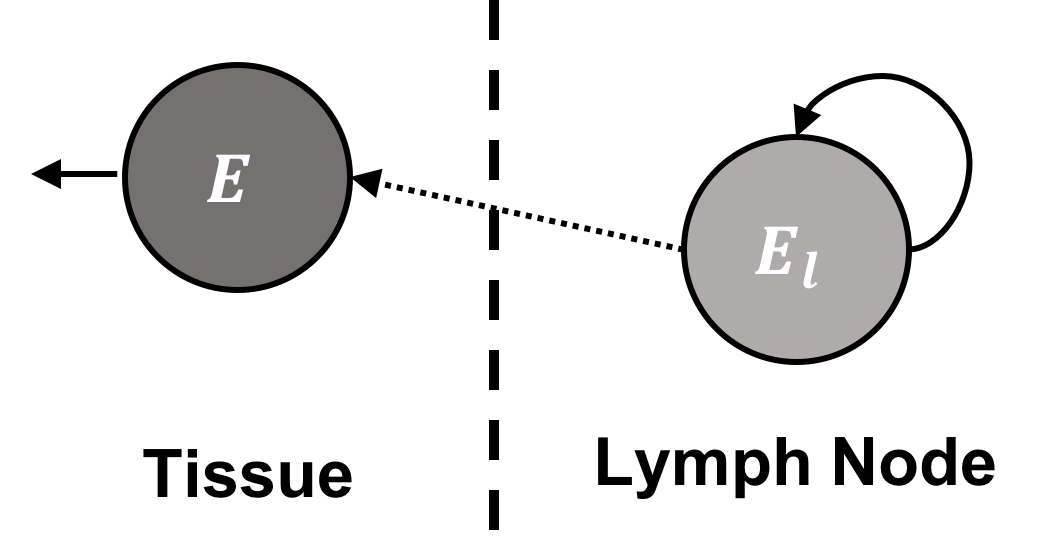
</div>

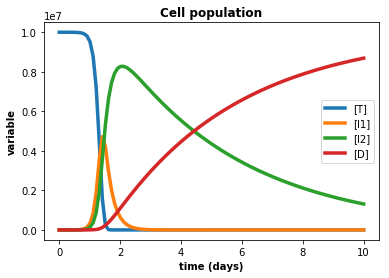

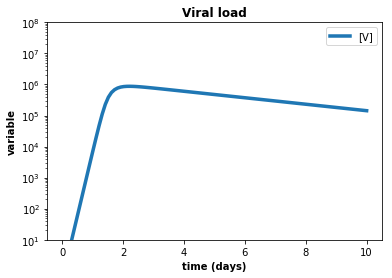

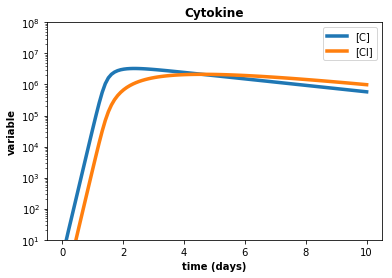

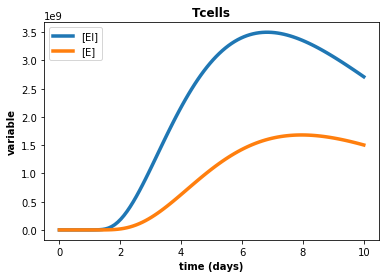

In [93]:
import tellurium as te
model_string = '''
    //Equations
    E1: T -> I1 ; beta*T*V ; //Infection rate
    E2: I1 -> I2 ; k*I1 ; //Infection rate
    E3: -> V ; p*I2 ; //Virus Production
    E4: V -> ; c*V ; // Virus Decay
    E5: I2 -> D ; d*I2 ; // Infected Cell Clearance (apopotosis + innate immune response)
    E6: -> C ; pc*(I1+I2) ; // Cytokine production
    E7: C -> ; cc*C ; // Cytokine decay
    E8: C -> Cl ; kc * C // Cytokine transport to the lymph node
    E9: Cl -> ; ccl * Cl // Lymph node cytokine decay
    E10: -> El ; pel*Cl + rel*Kel*Cl*El/(Kel + El) ;
    E11: El -> E; ke*El   ;
    E12: E ->  ; dE*E     ;
    
    
    //Parameters
    beta = 6.2E-5 ; // 1.0/(TCID*day)
    k = 4.0 ; // 1.0/day
    p = 1.0 ; // TCID/cell/day
    c = 9.4 ; // 1.0/day
    d = 2.4E-1; // 1.0/day
    pc = 1.0 ;
    cc = 2.0 ; // 1.0/day
    kc = 0.5 ; // 1.0/day
    ccl = 0.5 ; // 1.0/day
    pel = 1E-4 ;
    rel = 1.0 ;
    Kel = 1E3 ;
    ke = 0.5 ;
    dE = 1.0 ;
    

    //Inputs
    V = 0.0
    
    //Initial Conditions
    T0 = 1E7
    T = T0
    I1 = 75 
'''
m = te.loada(model_string)
s = m.simulate(0,10,100,['time','[T]','[I1]','[I2]','[D]'])
m.plot(title = "Cell population", xtitle="time (days)", ytitle="variable",linewidth=3.5)

m = te.loada(model_string)
s = m.simulate(0,10,100,['time','[V]'])
m.plot(title = "Viral load", xtitle="time (days)", ytitle="variable",linewidth=3.5,yscale='log',ylim=[10E0,10E7])
                         
m = te.loada(model_string)
s = m.simulate(0,10,100,['time','[C]','[Cl]'])
m.plot(title = "Cytokine", xtitle="time (days)", ytitle="variable",linewidth=3.5,yscale='log',ylim=[10E0,10E7])

m = te.loada(model_string)
s = m.simulate(0,10,100,['time','[El]','[E]'])
m.plot(title = "Tcells", xtitle="time (days)", ytitle="variable",linewidth=3.5)

# Tcell mediated cytotoxicity

Lasty, we model the adaptive immune response as T-cell mediated cytotoxicity. T-cells induce infected cell death by recognizing pathogen-associated proteins in the infected cell surface, which means that T-cells most find their target cells in the tissue. The rate of killing will then be a function of how easy is for T-cells ($E$) to encounter their target cells ($I_2$). We model this limiting factor by including a saturating term in the rate of cell killing that is dependent on both the number of infected cells ($I_2$) and the number of effector immune cells ($E$).

$\frac{dI_2}{dt}= kI_1 - dI_2 - d_{ei2} E I_2\frac{k_{ei2}}{k_{ei2}+E+I2} $

<div>
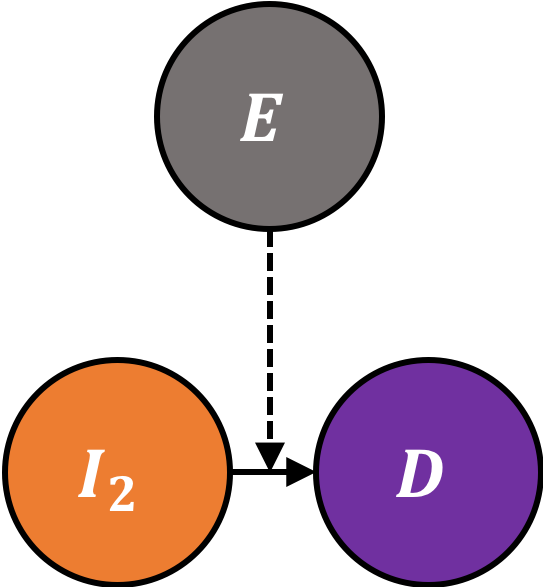
</div>

# Putting everything together

When putting the whole model together the system equations are as follow:

$\frac{dT}{dt}=-\beta T V$ 

$\frac{dI_1}{dt}=\beta T V - k I_1$

$\frac{dI_2}{dt}= kI_1 - dI_2 - d_{ei2} E I_2\frac{k_{ei2}}{k_{ei2}+E+I2} $

$\frac{dV}{dt}= pI_2 - cV$

$\frac{dC}{dt}= p_c(I_1+I_2) - c_cC - k_cC$

$\frac{dC_L}{dt}= k_cC - c_{cl}C_L$

$\frac{dE_L}{dt} = p_{el}C_L + r_{el} C_L E_L\frac{K_{el}}{E_L + K_{el}} - k_e E_L$

$\frac{dE}{dt} = k_e E_L - d_e E$

<div>
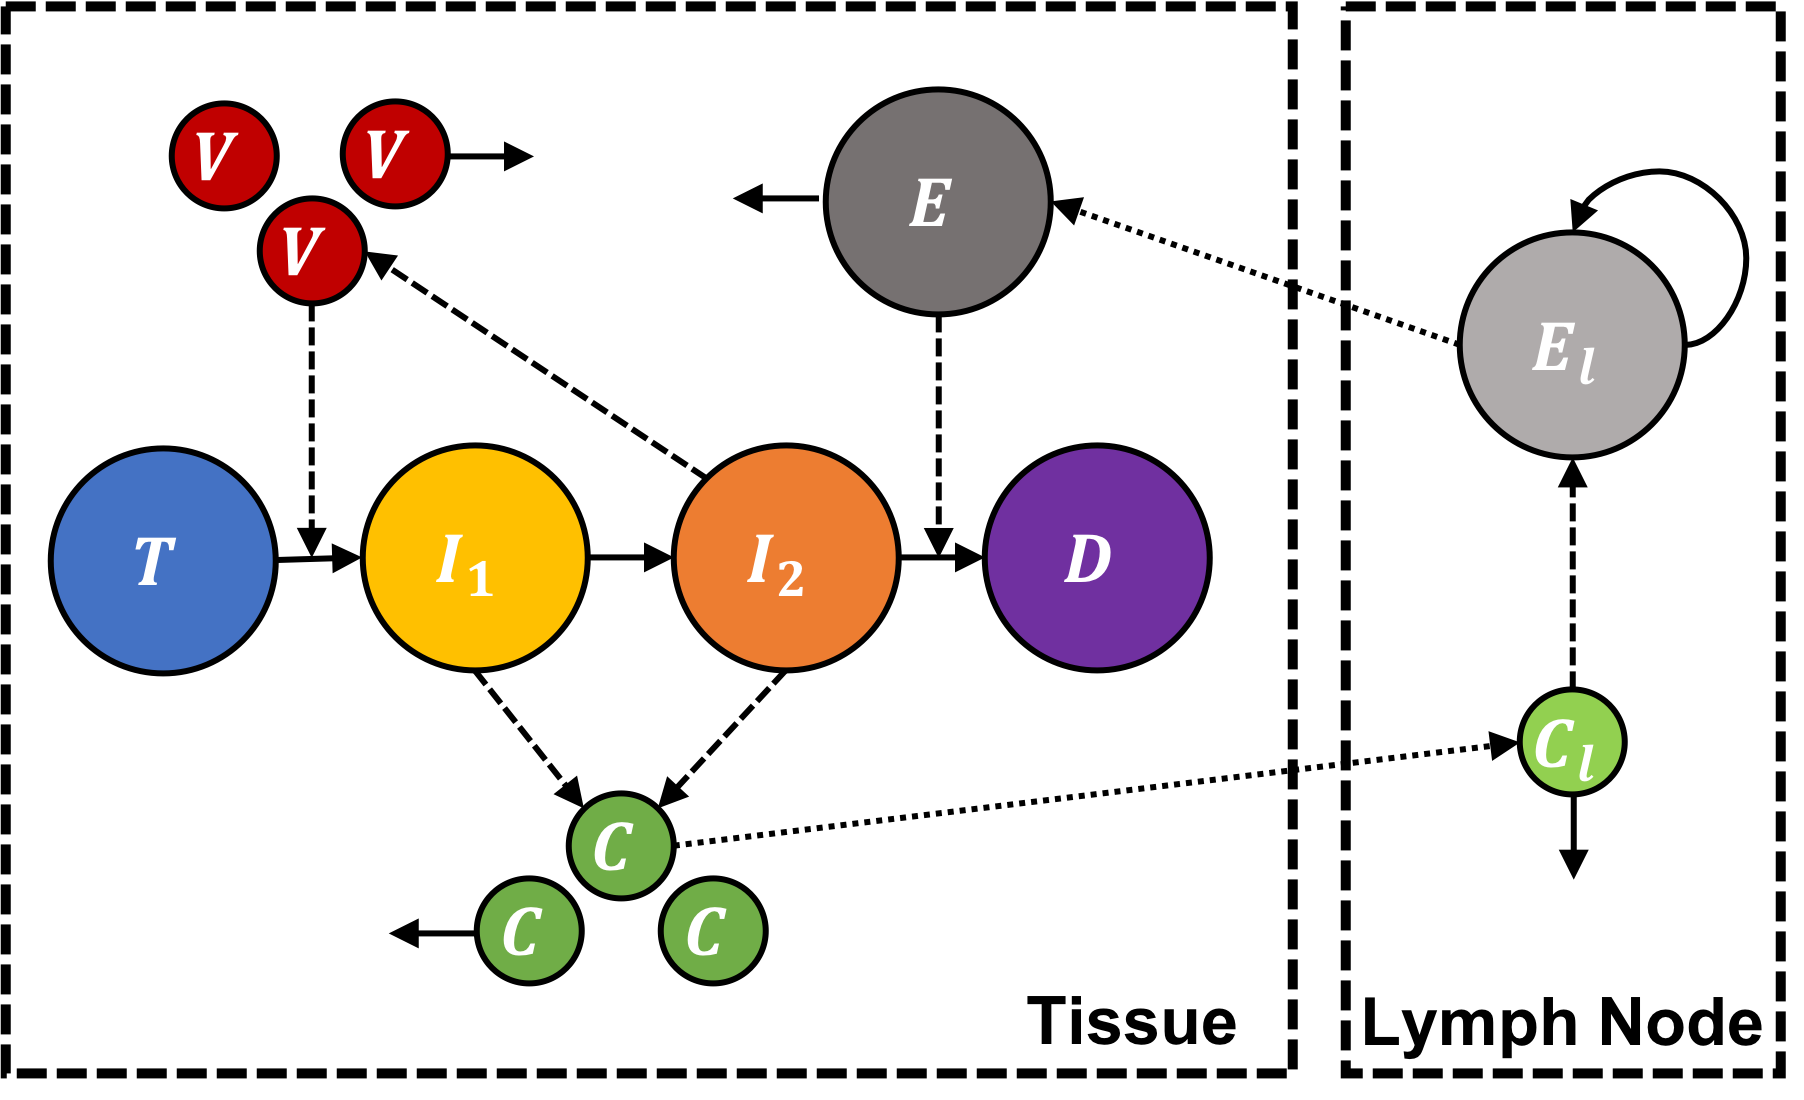
</div>

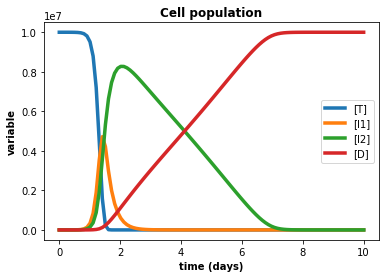

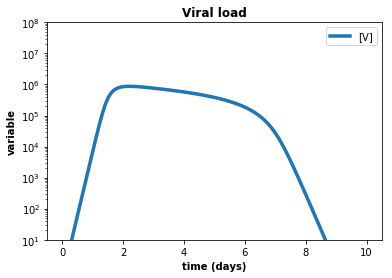

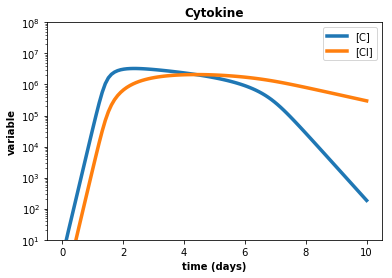

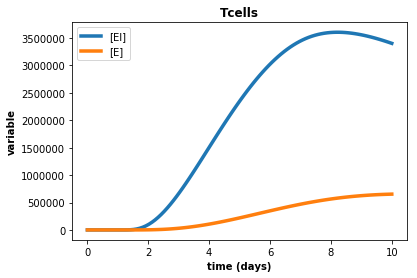

In [94]:
model_string = '''
    //Equations
    E1: T -> I1 ; beta*T*V ; //Infection rate
    E2: I1 -> I2 ; k*I1 ; //Infection rate
    E3: -> V ; p*I2 ; //Virus Production
    E4: V -> ; c*V ; // Virus Decay
    E5: I2 -> D ; d*I2 ; // Infected Cell Clearance (apopotosis + innate immune response)
    E6: -> C ; pc*(I1+I2) ; // Cytokine production
    E7: C -> ; cc*C ; // Cytokine decay
    E8: C -> Cl ; kc * C // Cytokine transport to the lymph node
    E9: Cl -> ; ccl * Cl // Lymph node cytokine decay
    E10: -> El ; pel*Cl + rel*Kel*Cl*El/(Kel + El) ;
    E11: El -> E; ke*El   ;
    E12: E ->  ; dE*E     ;
    E13: I2 -> D ; dei2*E*I2*kei2/(E+kei2+I2) ;
      
    //Parameters
    beta = 6.2E-5 ; // 1.0/(TCID*day)
    k = 4.0 ; // 1.0/day
    p = 1.0 ; // TCID/cell/day
    c = 9.4 ; // 1.0/day
    d = 2.4E-1; // 1.0/day
    pc = 1.0 ;
    cc = 2.0 ; // 1.0/day
    kc = 0.5 ; // 1.0/day
    ccl = 0.5 ; // 1.0/day
    pel = 1E-4 ;
    rel = 0.005 ;
    Kel = 100 ;
    ke = 0.1 ;
    dE = 0.5 ;
    dei2 =  1E-2;
    kei2 = 5E2;

    //Inputs
    V = 0.0
    
    //Initial Conditions
    T0 = 1E7
    T = T0
    I1 = 75 
'''

m = te.loada(model_string)
s = m.simulate(0,10,100,['time','[T]','[I1]','[I2]','[D]'])
m.plot(title = "Cell population", xtitle="time (days)", ytitle="variable",linewidth=3.5)

m = te.loada(model_string)
s = m.simulate(0,10,100,['time','[V]'])
m.plot(title = "Viral load", xtitle="time (days)", ytitle="variable",linewidth=3.5,yscale='log',ylim=[10E0,10E7])
                         
m = te.loada(model_string)
s = m.simulate(0,10,100,['time','[C]','[Cl]'])
m.plot(title = "Cytokine", xtitle="time (days)", ytitle="variable",linewidth=3.5,yscale='log',ylim=[10E0,10E7])

m = te.loada(model_string)
s = m.simulate(0,10,100,['time','[El]','[E]'])
m.plot(title = "Tcells", xtitle="time (days)", ytitle="variable",linewidth=3.5)

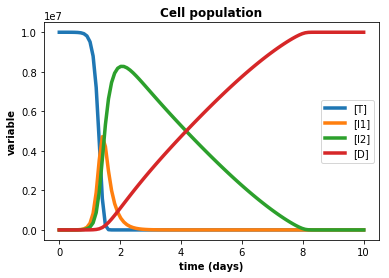

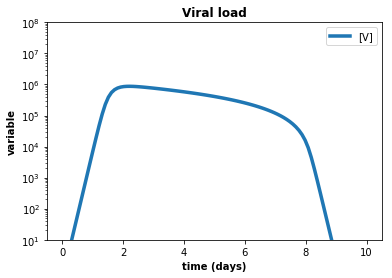

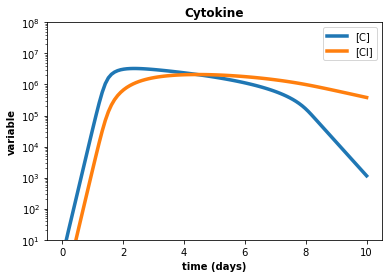

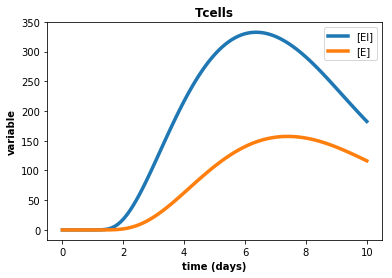

In [95]:
import tellurium as te
import matplotlib.pyplot as plt
import numpy as np
model_string = '''
    //Equations
    E1: T -> I1 ; beta*T*V ; //Infection rate
    E2: I1 -> I2 ; k*I1 ; //Infection rate
    E3: -> V ; p*I2 ; //Virus Production
    E4: V -> ; c*V ; // Virus Decay
    E5: I2 -> D ; d*I2 ; // Infected Cell Clearance (apopotosis + innate immune response)
    E6: -> C ; pc*(I1+I2) ; // Cytokine production
    E7: C -> ; cc*C ; // Cytokine decay
    E8: C -> Cl ; kc * C // Cytokine transport to the lymph node
    E9: Cl -> ; ccl * Cl // Lymph node cytokine decay
    E10: -> El ; pel*Cl + rel*El*Kel/(Kel + El) ;
    E11: El -> E; ke*El   ;
    E12: E ->  ; dE*E     ;
    E13: I2 -> D ; kei2*dei2*E/(E+kei2+I2)*I2 ;
    
    
    //Parameters
    beta = 6.2E-5 ; // 1.0/(TCID*day)
    k = 4.0 ; // 1.0/day
    p = 1.0 ; // TCID/cell/day
    c = 9.4 ; // 1.0/day
    d = 2.4E-1; // 1.0/day
    pc = 1.0 ;
    cc = 2.0 ; // 1.0/day
    kc = 0.5 ; // 1.0/day
    ccl = 0.5 ; // 1.0/day
    pel = 1E-4 ;
    rel = 1.0E-7 ;
    Kel = 1E3 ;
    ke = 0.5 ;
    dE = 1.0 ;
    dei2 = 12E-2 ; //15E3
    kei2 = 5E4 ;
    
    //Inputs
    V = 0.0
    
    //Initial Conditions
    T0 = 1E7
    T = T0
    I1 = 75 
'''
m = te.loada(model_string)
s = m.simulate(0,10,100,['time','[T]','[I1]','[I2]','[D]'])
m.plot(title = "Cell population", xtitle="time (days)", ytitle="variable",linewidth=3.5)

m = te.loada(model_string)
s = m.simulate(0,10,100,['time','[V]'])
m.plot(title = "Viral load", xtitle="time (days)", ytitle="variable",linewidth=3.5,yscale='log',ylim=[10E0,10E7])
                         
m = te.loada(model_string)
s = m.simulate(0,10,100,['time','[C]','[Cl]'])
m.plot(title = "Cytokine", xtitle="time (days)", ytitle="variable",linewidth=3.5,yscale='log',ylim=[10E0,10E7])

m = te.loada(model_string)
s = m.simulate(0,10,100,['time','[El]','[E]'])
m.plot(title = "Tcells", xtitle="time (days)", ytitle="variable",linewidth=3.5)